# **Data Visualization**

## Objectives

* Address business requirement 1 by conducting a visual study of cherry leaves to distinguish healthy leaves from those infected with powdery mildew.
* Additional objective: To create a montage of images to facilitate visual comparison and presentation on the dashboard.

## Inputs

* Dataset containing cherry leaf images, organized in:
    * inputs/cherry-leaves/train
    * inputs/cherry-leaves/test
    * inputs/cherry-leaves/validation
* Output directory for saving graphs and results:
    * outputs/{version}

## Outputs

* Visualisations of the mean and variability of the images per label
* Visual comparison of average images between healthy and mildewed leaves.
* Montage of images showing examples of each class to facilitate visual analysis.
* Saved graphics that can be used in the final dashboard.

## Additional Comments

* No comments.



---

## Import Packages

In [2]:
import os  # Working with directories and file paths
import numpy as np  # Numerical operations and array manipulations
import matplotlib.pyplot as plt  # Plotting graphs and image montages
import seaborn as sns  # Enhancing plots with Seaborn styles
import joblib  # Saving and loading variables
sns.set_style("white")
from imageio import imread  # Loading images for analysis
from tensorflow.keras.preprocessing import image  # Preprocessing images as arrays
import itertools  # Generating index combinations for image montage
import random  # Randomizing image selection in the montage

# Change working directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [5]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [6]:
current_dir = os.getcwd()
current_dir

'/workspace/Mildew-Detection-in-Cherry-Leaves'

## Set input directories
 Set input directories (train, validation, test)

In [7]:
my_data_dir = 'inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [8]:
# Set output directory
version = 'v1'
file_path = f'outputs/{version}'

# Check if version folder already exists, if not, create one
if 'outputs' in os.listdir() and version in os.listdir('outputs'):
    print('Old version is already available, create a new version.')
else:
    os.makedirs(file_path)
    print(f'Output directory created at: {file_path}')

Output directory created at: outputs/v1


## Set label names

In [9]:
# Set the labels
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['healthy', 'powdery_mildew']


---

## Prepare Dataset

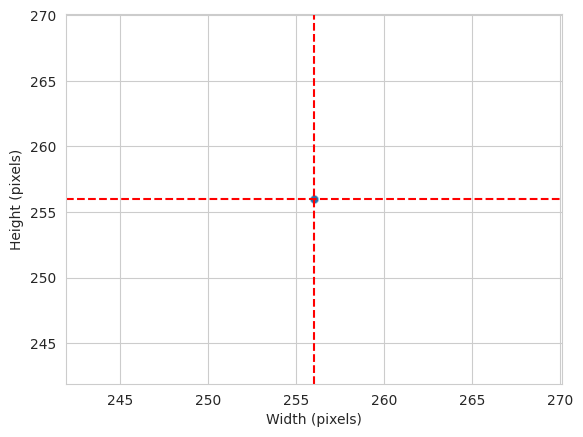

Average width: 256 
Average height: 256


['outputs/v1/image_shape.pkl']

In [10]:
# Compute average image dimensions from the training set
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

# Plot the width and height of the images
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2, ax=axes)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())

# Add reference lines for the mean width and height
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()

print(f"Average width: {dim2_mean} \nAverage height: {dim1_mean}")

# Save the average image shape
image_shape = (dim1_mean, dim2_mean, 3)  # assuming 3 color channels (RGB)
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

---

# Calculate Average Image Dimensions

## Function to load images in an array

In [11]:
def process_images_to_array(data_directory, image_size=(100, 100), max_images=None):
    """
    This function loads images from the specified directory, resizes them,
    and converts them into arrays. It also assigns labels based on the folder structure.
    
    Args:
    - data_directory: Directory containing the images, organized by labels.
    - image_size: Target size to resize the images (now 100x100 by default).
    - max_images: Maximum number of images to load per label (optional).
    
    Returns:
    - X: Array containing the image data.
    - y: Array containing the corresponding labels.
    """
    X, y = [], []
    labels = os.listdir(data_directory)
    
    # Iterate through the labels (e.g., healthy, infected)
    for label in labels:
        image_count = 0
        label_dir = os.path.join(data_directory, label)
        
        # Iterate through the images in each label's folder
        for img_file in os.listdir(label_dir):
            if max_images and image_count >= max_images:
                break  # Stop if the maximum image limit is reached
            
            # Load and resize the image
            img_path = os.path.join(label_dir, img_file)
            img = image.load_img(img_path, target_size=image_size)
            img_array = image.img_to_array(img) / 255.0  # Normalize to 0-1 range
            
            # Append the image and label to the arrays
            X.append(img_array)
            y.append(label)
            
            image_count += 1
    
    return np.array(X), np.array(y)

### Example usage

In [12]:
X, y = process_images_to_array(data_directory=train_path, image_size=(100, 100), max_images=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


## Visualize Mean and Variability of Images per Label

Label: healthy
Image Shape: (100, 100, 3)


Label: powdery_mildew
Image Shape: (100, 100, 3)




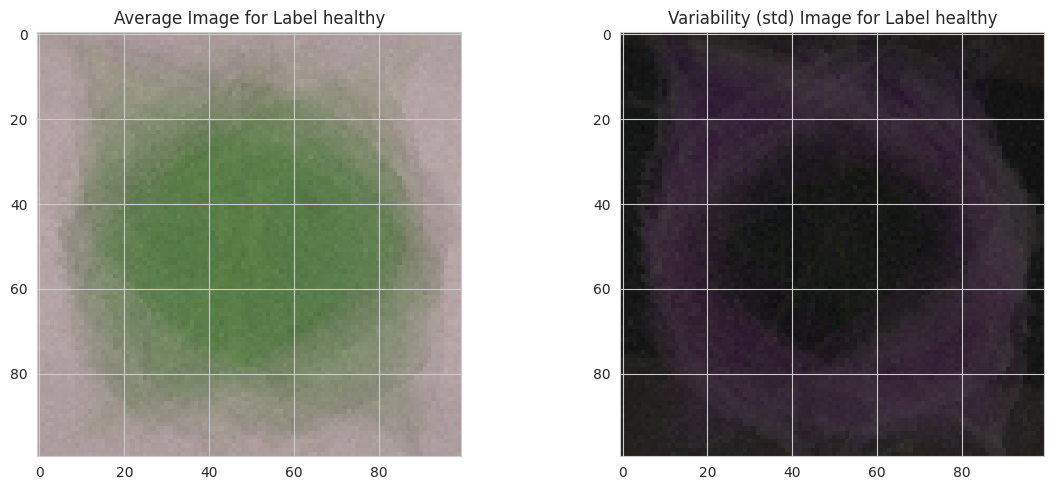

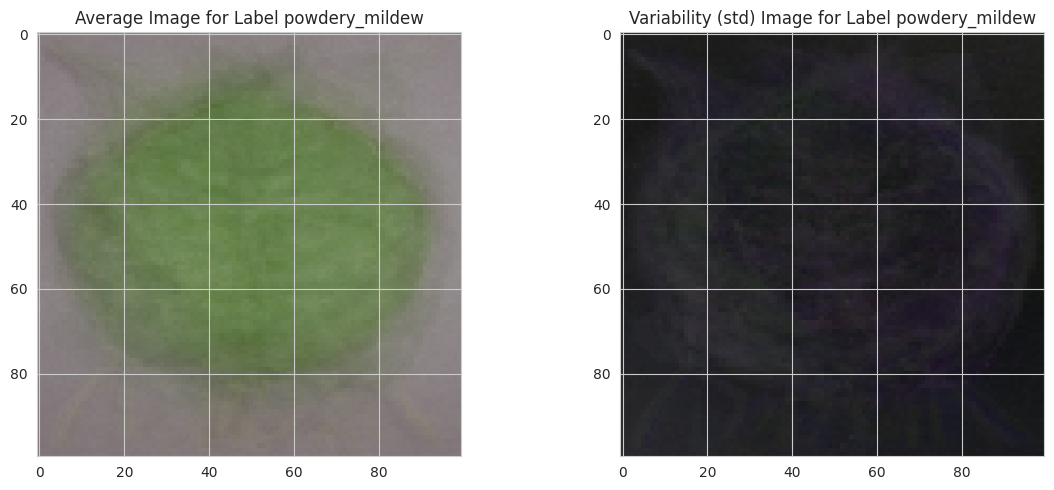

In [13]:
def visualize_mean_variability(images, labels, figure_size=(12, 5), save=False):
    """
    Visualizes and optionally saves the mean and variability (std) of images for each label.
    
    Args:
    - images: Array of images.
    - labels: Corresponding labels for the images.
    - figure_size: Size of the figure for the plot.
    - save: Whether to save the plot as an image file.
    
    Returns:
    - Displays the plots showing mean and variability for each label.
    """
    unique_labels = np.unique(labels)
    
    # Iterate over each unique label and compute the mean and std
    for label in unique_labels:
        sns.set_style("whitegrid")
        
        # Filter the images by the current label
        label_filter = labels == label
        selected_images = images[label_filter]
        
        # Calculate mean and standard deviation
        mean_image = np.mean(selected_images, axis=0)
        std_image = np.std(selected_images, axis=0)
        
        # Print shapes of mean and std images
        print(f"Label: {label}")
        print(f"Image Shape: {mean_image.shape}")
        
        # Plot the results
        fig, ax = plt.subplots(1, 2, figsize=figure_size)
        ax[0].set_title(f"Average Image for Label {label}")
        ax[0].imshow(mean_image, cmap='gray')
        
        ax[1].set_title(f"Variability (std) Image for Label {label}")
        ax[1].imshow(std_image, cmap='gray')
        
        plt.tight_layout()
        
        # Optionally save the plot as a file
        if save:
            plt.savefig(f"{file_path}/mean_var_label_{label}.png", bbox_inches='tight', dpi=150)
        else:
            plt.show()
        print("\n")

# Example usage
visualize_mean_variability(X, y, figure_size=(12, 5), save=True)

---

## Compare Average Images Between Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


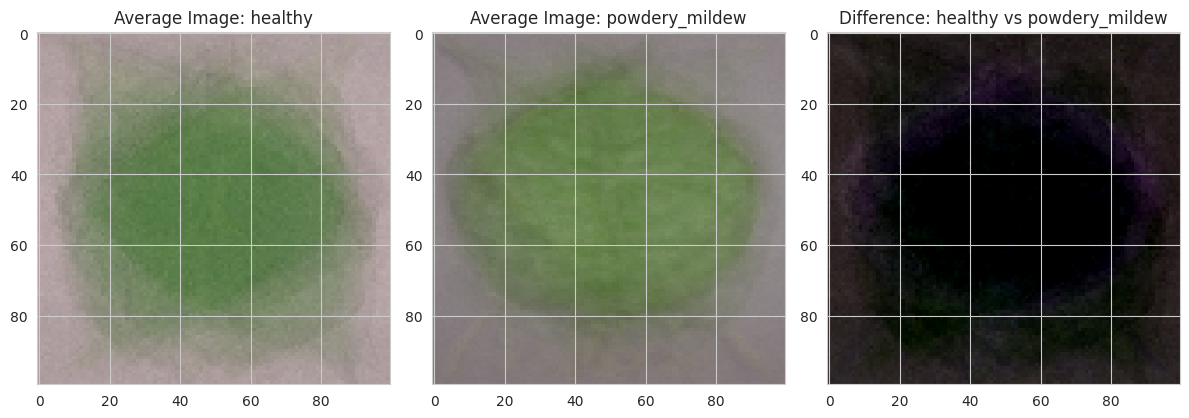

In [14]:
def filter_images_by_label(images, labels, selected_label):
    """
    Filters images based on the specified label.
    
    Args:
    - images: Array of images.
    - labels: Corresponding labels.
    - selected_label: Label to filter by.
    
    Returns:
    - Subset of images corresponding to the selected label.
    """
    boolean_mask = labels == selected_label
    filtered_images = images[boolean_mask]
    return filtered_images

def compare_average_images(images, labels, label1, label2, figure_size=(20, 5), save=False):
    """
    Compares the average images of two different labels and plots the difference.
    
    Args:
    - images: Array of images.
    - labels: Corresponding labels for the images.
    - label1: First label to compare.
    - label2: Second label to compare.
    - figure_size: Size of the figure for the plot.
    - save: Whether to save the plot as an image file.
    
    Returns:
    - Displays the plots showing average images and their difference.
    """
    sns.set_style("whitegrid")
    
    # Ensure both labels exist in the dataset
    if label1 not in np.unique(labels) or label2 not in np.unique(labels):
        print(f"Either {label1} or {label2} not found in the labels.")
        return
    
    # Calculate average image for each label
    images_label1 = filter_images_by_label(images, labels, label1)
    avg_image_label1 = np.mean(images_label1, axis=0)
    
    images_label2 = filter_images_by_label(images, labels, label2)
    avg_image_label2 = np.mean(images_label2, axis=0)
    
    # Calculate the difference between the two average images
    diff_image = avg_image_label1 - avg_image_label2
    
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=figure_size)
    axes[0].imshow(avg_image_label1, cmap='gray')
    axes[0].set_title(f"Average Image: {label1}")
    
    axes[1].imshow(avg_image_label2, cmap='gray')
    axes[1].set_title(f"Average Image: {label2}")
    
    axes[2].imshow(diff_image, cmap='gray')
    axes[2].set_title(f"Difference: {label1} vs {label2}")
    
    plt.tight_layout()
    
    # Optionally save the plot as a file
    if save:
        plt.savefig(f"{file_path}/avg_diff_{label1}_vs_{label2}.png", bbox_inches='tight', dpi=150)
    else:
        plt.show()

# Example usage
compare_average_images(X, y, label1="healthy", label2="powdery_mildew", figure_size=(12, 10), save=True)

## Create Image Montage for Each Label

/tmp/ipykernel_11065/1609360636.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)


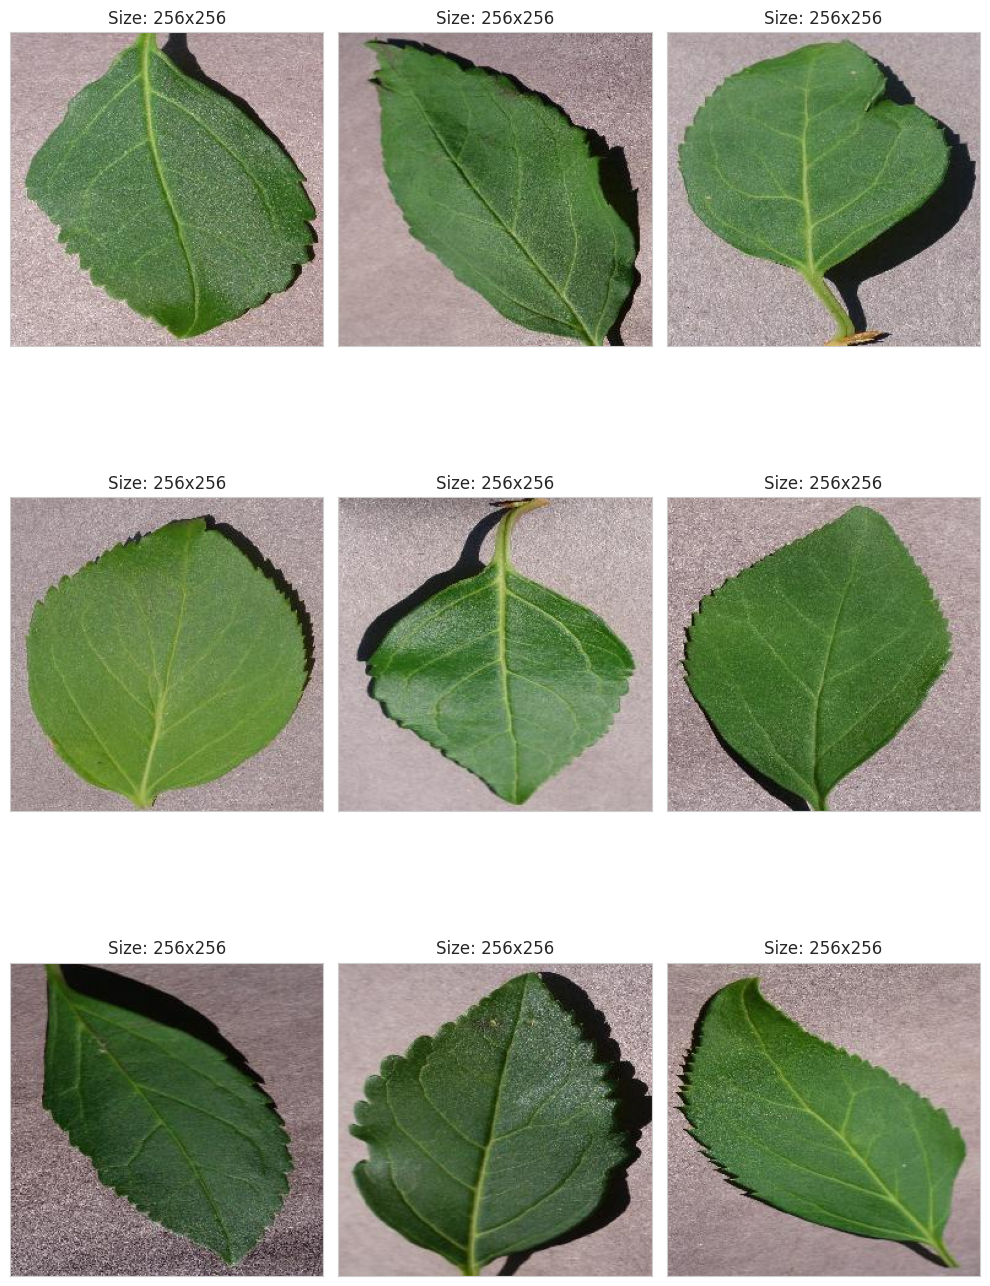

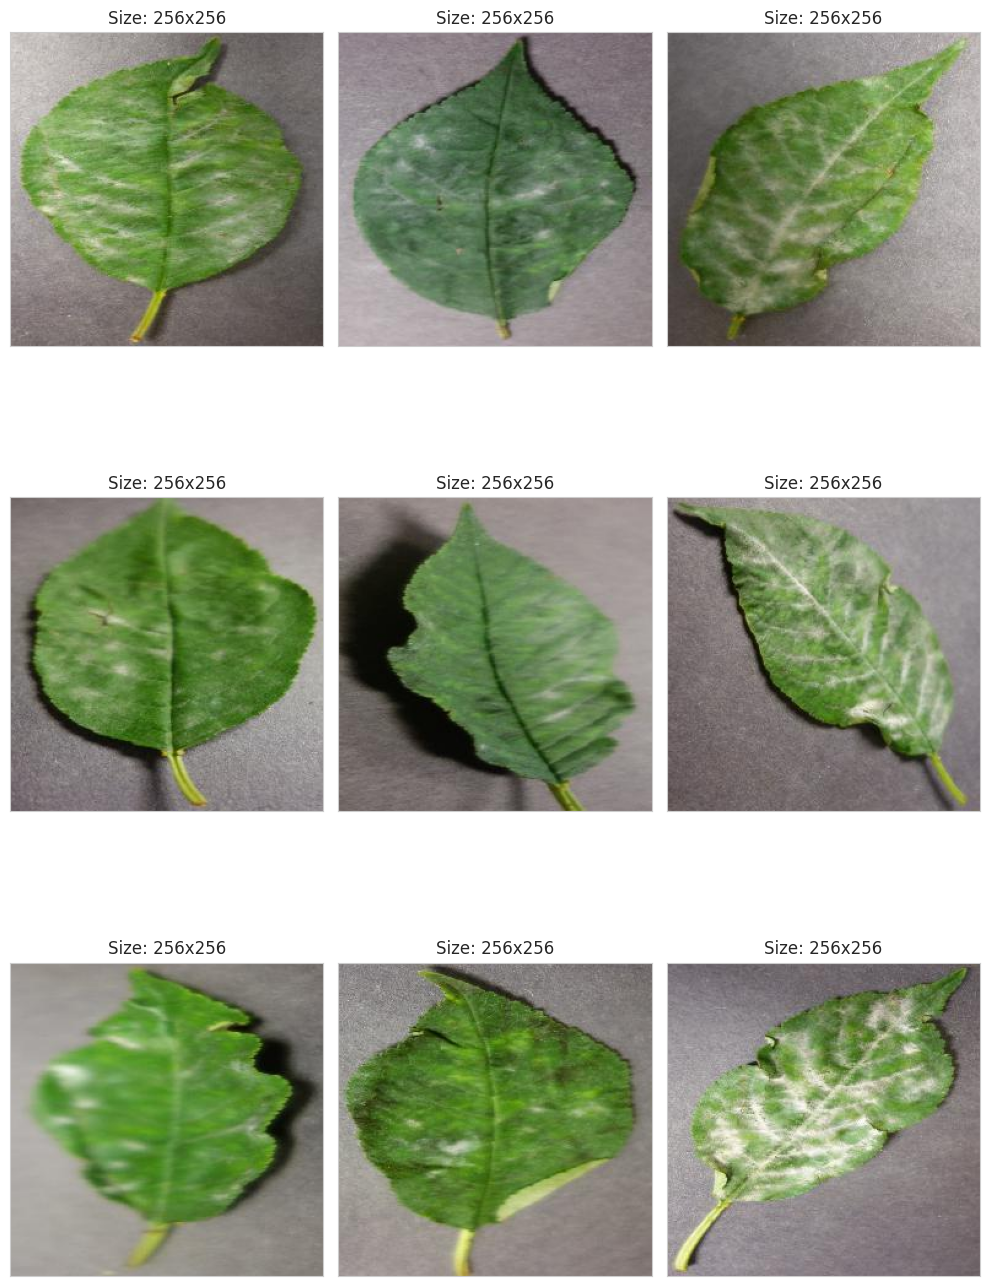

In [16]:
sns.set_style("whitegrid")

def create_image_montage(image_dir, label, rows, cols, figure_size=(15, 10)):
    """
    Creates a montage of images for a specified label, displayed in a grid of rows and columns.
    
    Args:
    - image_dir: Directory where the images are stored.
    - label: The label of the images to display (e.g., healthy, powdery_mildew).
    - rows: Number of rows in the montage.
    - cols: Number of columns in the montage.
    - figure_size: Size of the output figure.
    
    Returns:
    - A montage of images displayed in a grid.
    """
    labels = os.listdir(image_dir)
    
    # Check if the specified label exists
    if label not in labels:
        print(f"The label '{label}' doesn't exist.")
        print(f"Available labels are: {labels}")
        return
    
    # Get the images for the specified label
    image_list = os.listdir(f"{image_dir}/{label}")
    
    # Check if there are enough images to fill the montage grid
    if rows * cols > len(image_list):
        print(f"Decrease the number of rows or columns. You requested a montage with {rows * cols} spaces, but only {len(image_list)} images are available.")
        return
    
    # Create grid indices for plotting
    grid_rows = range(rows)
    grid_cols = range(cols)
    grid_indices = list(itertools.product(grid_rows, grid_cols))
    
    # Create the figure for the montage
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figure_size)
    
    for idx, (row, col) in enumerate(grid_indices):
        if idx >= len(image_list):
            break
        
        img_path = f"{image_dir}/{label}/{image_list[idx]}"
        img = imread(img_path)
        
        # Plot the image
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Size: {img.shape[1]}x{img.shape[0]}")
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
    
    plt.tight_layout()
    plt.show()

# Example usage
for label in labels:
    create_image_montage(image_dir=train_path, label=label, rows=3, cols=3, figure_size=(10, 15))


## Conclusions

* The images of the dataset were correctly uploaded and processed for analysis of their dimensions and visual characteristics.
* The average images and the variability between classes were calculated, providing valuable information on the differences between healthy leaves and those with downy mildew.
* The image montage generated an effective visualisation of the images of each class, which facilitates a quick inspection of the visual characteristics of each group.